Imports

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimpy import skim
import spacy
from collections import Counter
import re

In [45]:
from tqdm import tqdm

Dataset loading

In [33]:
from datasets import load_dataset

ds = load_dataset("DataForGood/ome-hackathon-season-14")

C:\Users\moonb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [34]:
df = pd.DataFrame(ds['train'])
df.head()

,channel_title,channel_name,country,segment_id,segment_start,segment_end,duration_seconds,num_keywords,avg_density,themes,report_text,category,secondary_categories,text_type
0,France 2,france2,france,2732,2025-06-19 07:06:11.061 +0200,2025-06-19 07:07:25.070 +0200,74,9,8.1,"attenuation_climatique_solutions, biodiversite...",ne parviennent pas à toutes les évacuer ces al...,other,[],segment
1,TF1,tf1,france,3973,2025-10-08 20:18:42.012 +0200,2025-10-08 20:19:46.044 +0200,64,12,11.0,"biodiversite_causes, biodiversite_concepts_gen...",plus important était réalisée il faut souligne...,mobility_transport,[],segment
2,France 2,france2,france,5788,2025-12-03 06:34:04.031 +0100,2025-12-03 06:36:02.025 +0100,118,18,13.4,", attenuation_climatique_solutions_indirectes,...",plus vendu au monde a la une également cette c...,agriculture_alimentation,[energy],segment
3,M6,m6,france,3445,2025-11-17 15:20:24.048 +0100,2025-11-17 15:21:26.064 +0100,62,4,5.3,", biodiversite_causes_indirectes, changement_c...",christo popov thomas fersen ces enseignants et...,agriculture_alimentation,[],segment
4,TF1,tf1,france,354,2025-01-30 08:44:59.024 +0100,2025-01-30 08:46:29.034 +0100,90,9,8.1,"attenuation_climatique_solutions, biodiversite...",ce sont nos confrères du figaro qui nous en pa...,other,[],report


Data exploration

In [11]:
df.info

<bound method DataFrame.info of      channel_title channel_name country  segment_id  \
0         France 2      france2  france        2732   
1              TF1          tf1  france        3973   
2         France 2      france2  france        5788   
3               M6           m6  france        3445   
4              TF1          tf1  france         354   
...            ...          ...     ...         ...   
8344      France 2      france2  france        3614   
8345           TF1          tf1  france        4712   
8346      France 2      france2  france        2126   
8347  France 3-idf      fr3-idf  france         778   
8348      France 2      france2  france        5205   

                      segment_start                    segment_end  \
0     2025-06-19 07:06:11.061 +0200  2025-06-19 07:07:25.070 +0200   
1     2025-10-08 20:18:42.012 +0200  2025-10-08 20:19:46.044 +0200   
2     2025-12-03 06:34:04.031 +0100  2025-12-03 06:36:02.025 +0100   
3     2025-11-17 15:20:24.0

In [ ]:
skim(df)

In [15]:
df['themes']

0       attenuation_climatique_solutions, biodiversite...
1       biodiversite_causes, biodiversite_concepts_gen...
2       , attenuation_climatique_solutions_indirectes,...
3       , biodiversite_causes_indirectes, changement_c...
4       attenuation_climatique_solutions, biodiversite...
                              ...                        
8344    attenuation_climatique_solutions, biodiversite...
8345    , biodiversite_concepts_generaux_indirectes, c...
8346    attenuation_climatique_solutions_indirectes, b...
8347    adaptation_climatique_solutions, attenuation_c...
8348    biodiversite_causes_indirectes, biodiversite_c...
Name: themes, Length: 8349, dtype: object

In [21]:
# Toutes les valeurs uniques de category
print("Catégories uniques:")
print(df['category'].unique())
print(f"\nNombre de catégories uniques: {df['category'].nunique()}")
print("\nDistribution des catégories:")
print(df['category'].value_counts())

Catégories uniques:
['other' 'mobility_transport' 'agriculture_alimentation' 'energy']

Nombre de catégories uniques: 4

Distribution des catégories:
category
other                       2903
agriculture_alimentation    2565
mobility_transport          1727
energy                      1154
Name: count, dtype: int64


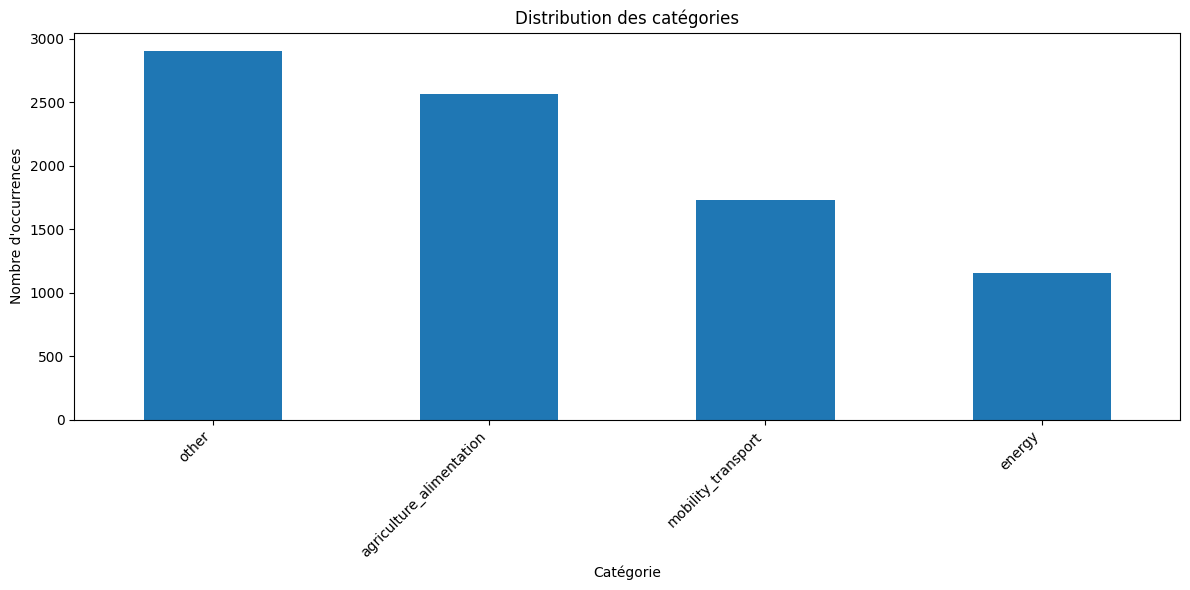

In [22]:
# Visualisation de la distribution des catégories
plt.figure(figsize=(12, 6))
df['category'].value_counts().plot(kind='bar')
plt.title('Distribution des catégories')
plt.xlabel('Catégorie')
plt.ylabel('Nombre d\'occurrences')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [37]:
# Filtrer le dataset sur la catégorie agriculture_alimentation
df_agri = df[df['category'] == 'agriculture_alimentation']
print(f"Nombre d'observations dans la catégorie agriculture_alimentation: {len(df_agri)}")
print(f"\nPourcentage du dataset total: {len(df_agri)/len(df)*100:.2f}%")
print(f"\nAperçu des données filtrées:")
df_agri.head(10)

Nombre d'observations dans la catégorie agriculture_alimentation: 2565

Pourcentage du dataset total: 30.72%

Aperçu des données filtrées:


,channel_title,channel_name,country,segment_id,segment_start,segment_end,duration_seconds,num_keywords,avg_density,themes,report_text,category,secondary_categories,text_type
2,France 2,france2,france,5788,2025-12-03 06:34:04.031 +0100,2025-12-03 06:36:02.025 +0100,118,18,13.4,", attenuation_climatique_solutions_indirectes,...",plus vendu au monde a la une également cette c...,agriculture_alimentation,[energy],segment
3,M6,m6,france,3445,2025-11-17 15:20:24.048 +0100,2025-11-17 15:21:26.064 +0100,62,4,5.3,", biodiversite_causes_indirectes, changement_c...",christo popov thomas fersen ces enseignants et...,agriculture_alimentation,[],segment
9,M6,m6,france,1379,2025-05-13 20:14:11.059 +0200,2025-05-13 20:15:50.004 +0200,99,8,8.1,"attenuation_climatique_solutions_indirectes, b...",la baignade tourne court sera <unk> occasion d...,agriculture_alimentation,[],segment
14,TF1,tf1,france,4852,2025-12-25 09:11:59.056 +0100,2025-12-25 09:13:11.082 +0100,72,15,17.2,"adaptation_climatique_solutions, attenuation_c...",le jardin ce ne sont pas uniquement des matièr...,agriculture_alimentation,[],segment
17,France 2,france2,france,5744,2025-11-30 07:36:06.090 +0100,2025-11-30 07:38:37.058 +0100,151,11,10.5,"biodiversite_causes, biodiversite_concepts_gen...",aux etats-unis que pensez-vous d' aller faire ...,agriculture_alimentation,[],segment
20,France 2,france2,france,2000,2025-05-07 06:42:01.096 +0200,2025-05-07 06:44:57.032 +0200,176,22,16.0,", adaptation_climatique_solutions_indirectes, ...",l' après-midi sur la moitié sud du pays côté t...,agriculture_alimentation,[],report
21,M6,m6,france,3667,2025-12-09 13:18:27.001 +0100,2025-12-09 13:19:43.024 +0100,76,16,23.6,", adaptation_climatique_solutions_indirectes, ...",premier long métrage sans son compère gustave ...,agriculture_alimentation,[mobility_transport],segment
23,France 3-idf,fr3-idf,france,3499,2025-12-31 12:10:01.042 +0100,2025-12-31 12:11:44.095 +0100,103,11,14.2,", biodiversite_concepts_generaux_indirectes, c...",quatorze et quinze degrés assurance bertrand l...,agriculture_alimentation,[],segment
24,M6,m6,france,830,2025-03-21 20:08:42.054 +0100,2025-03-21 20:11:03.066 +0100,141,32,23.3,", attenuation_climatique_solutions, biodiversi...",mais encore faut-il le savoir moi dans mon cer...,agriculture_alimentation,[energy],segment
28,TF1,tf1,france,1228,2025-04-10 08:32:11.013 +0200,2025-04-10 08:33:14.007 +0200,63,4,4.3,", biodiversite_concepts_generaux_indirectes, c...",poupon julia scher sur place ça c' est un de n...,agriculture_alimentation,[],report


## Analyse des thèmes

In [25]:
# Analyse des thèmes
print("Exemple de thèmes:")
print(df_agri['themes'].head(10))
print(f"\nNombre total de thèmes uniques: {df['themes'].nunique()}")

Exemple de thèmes:
2     , attenuation_climatique_solutions_indirectes,...
3     , biodiversite_causes_indirectes, changement_c...
9     attenuation_climatique_solutions_indirectes, b...
14    adaptation_climatique_solutions, attenuation_c...
17    biodiversite_causes, biodiversite_concepts_gen...
20    , adaptation_climatique_solutions_indirectes, ...
21    , adaptation_climatique_solutions_indirectes, ...
23    , biodiversite_concepts_generaux_indirectes, c...
24    , attenuation_climatique_solutions, biodiversi...
28    , biodiversite_concepts_generaux_indirectes, c...
Name: themes, dtype: object

Nombre total de thèmes uniques: 6297


## Statistiques descriptives

In [26]:
# Informations générales sur le dataset
print(f"Nombre total d'observations: {len(df_agri)}")
print(f"Nombre de colonnes: {len(df.columns)}")
print(f"\nNom des colonnes:")
print(df.columns.tolist())
print(f"\nTypes de données:")
print(df.dtypes)
print(f"\nValeurs manquantes:")
print(df.isnull().sum())

Nombre total d'observations: 2565
Nombre de colonnes: 14

Nom des colonnes:
['channel_title', 'channel_name', 'country', 'segment_id', 'segment_start', 'segment_end', 'duration_seconds', 'num_keywords', 'avg_density', 'themes', 'report_text', 'category', 'secondary_categories', 'text_type']

Types de données:
channel_title            object
channel_name             object
country                  object
segment_id                int64
segment_start            object
segment_end              object
duration_seconds          int64
num_keywords              int64
avg_density             float64
themes                   object
report_text              object
category                 object
secondary_categories     object
text_type                object
dtype: object

Valeurs manquantes:
channel_title           0
channel_name            0
country                 0
segment_id              0
segment_start           0
segment_end             0
duration_seconds        0
num_keywords            

## NER

In [33]:
pip install spacy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\moonb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [37]:
import os
os.system("python -m spacy download fr_core_news_sm")

0

In [15]:
import spacy

# Load French NER model
nlp = spacy.load("fr_core_news_sm")

In [50]:
def clean_text(text: str) -> str:
    """Clean text before NER processing"""
    if not isinstance(text, str):
        return ""
    # Remove extra whitespace and special chars
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def extract_actors(text: str):
    """Extract persons and organizations from text using spaCy NER"""
    if not isinstance(text, str) or not text.strip():
        return {"person": [], "organization": []}
    
    # Clean and process text (limit to first 2000 chars for speed)
    text = clean_text(text)
    doc = nlp(text[:2000])
    
    persons = []
    organizations = []
    
    # Extract named entities with confidence filtering
    for ent in doc.ents:
        entity_text = ent.text.strip()
        # Filter out very short entities and numbers
        if len(entity_text) > 2 and not entity_text.isdigit():
            if ent.label_ == "PER":
                persons.append(entity_text)
            elif ent.label_ == "ORG":
                organizations.append(entity_text)
    
    return {
        "person": list(set(persons)),
        "organization": list(set(organizations))
    }

# Apply NER extraction
actor_data = df_agri['report_text'].apply(extract_actors)

df_agri["actor_persons"] = actor_data.apply(lambda d: d["person"])
df_agri["actor_organizations"] = actor_data.apply(lambda d: d["organization"])

df_agri["actor"] = actor_data.apply(lambda d: {
    "persons": d["person"],
    "organizations": d["organization"]
})

print("Extraction NER complétée!")

Extraction NER complétée!


C:\Users\moonb\AppData\Local\Temp\ipykernel_21240\245955766.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["actor_persons"] = actor_data.apply(lambda d: d["person"])
C:\Users\moonb\AppData\Local\Temp\ipykernel_21240\245955766.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["actor_organizations"] = actor_data.apply(lambda d: d["organization"])
C:\Users\moonb\AppData\Local\Temp\ipykernel_21240\245955766.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [31]:
df_agri.head(10)

NameError: name 'df_agri' is not defined

In [51]:
# Analyse détaillée des acteurs extraits
print("="*80)
print("ANALYSE DÉTAILLÉE DES ACTEURS EXTRAITS")
print("="*80)

# Collecter tous les acteurs
all_persons = []
all_orgs = []

for persons_list in df_agri['actor_persons']:
    all_persons.extend(persons_list)
for orgs_list in df_agri['actor_organizations']:
    all_orgs.extend(orgs_list)

# Statistiques globales
print(f"\nNombre total d'occurrences de personnes: {len(all_persons)}")
print(f"Nombre de personnes uniques: {len(set(all_persons))}")
print(f"\nNombre total d'occurrences d'organisations: {len(all_orgs)}")
print(f"Nombre d'organisations uniques: {len(set(all_orgs))}")

# Top 20 personnes
print("\n" + "="*80)
print("TOP 20 PERSONNES LES PLUS MENTIONNÉES")
print("="*80)
persons_counter = Counter(all_persons)
for person, count in persons_counter.most_common(20):
    print(f"  {person:50s} | {count:3d} occurrences")

# Top 20 organisations
print("\n" + "="*80)
print("TOP 20 ORGANISATIONS LES PLUS MENTIONNÉES")
print("="*80)
orgs_counter = Counter(all_orgs)
for org, count in orgs_counter.most_common(20):
    print(f"  {org:50s} | {count:3d} occurrences")

ANALYSE DÉTAILLÉE DES ACTEURS EXTRAITS

Nombre total d'occurrences de personnes: 4552
Nombre de personnes uniques: 3066

Nombre total d'occurrences d'organisations: 766
Nombre d'organisations uniques: 361

TOP 20 PERSONNES LES PLUS MENTIONNÉES
  donald trump                                       |  79 occurrences
  emmanuel macron                                    |  44 occurrences
  frédéric                                           |  34 occurrences
  philippe                                           |  28 occurrences
  françois bayrou                                    |  28 occurrences
  ben                                                |  26 occurrences
  thomas                                             |  24 occurrences
  mathieu                                            |  23 occurrences
  guillaume                                          |  23 occurrences
  julia                                              |  22 occurrences
  antoine                                     

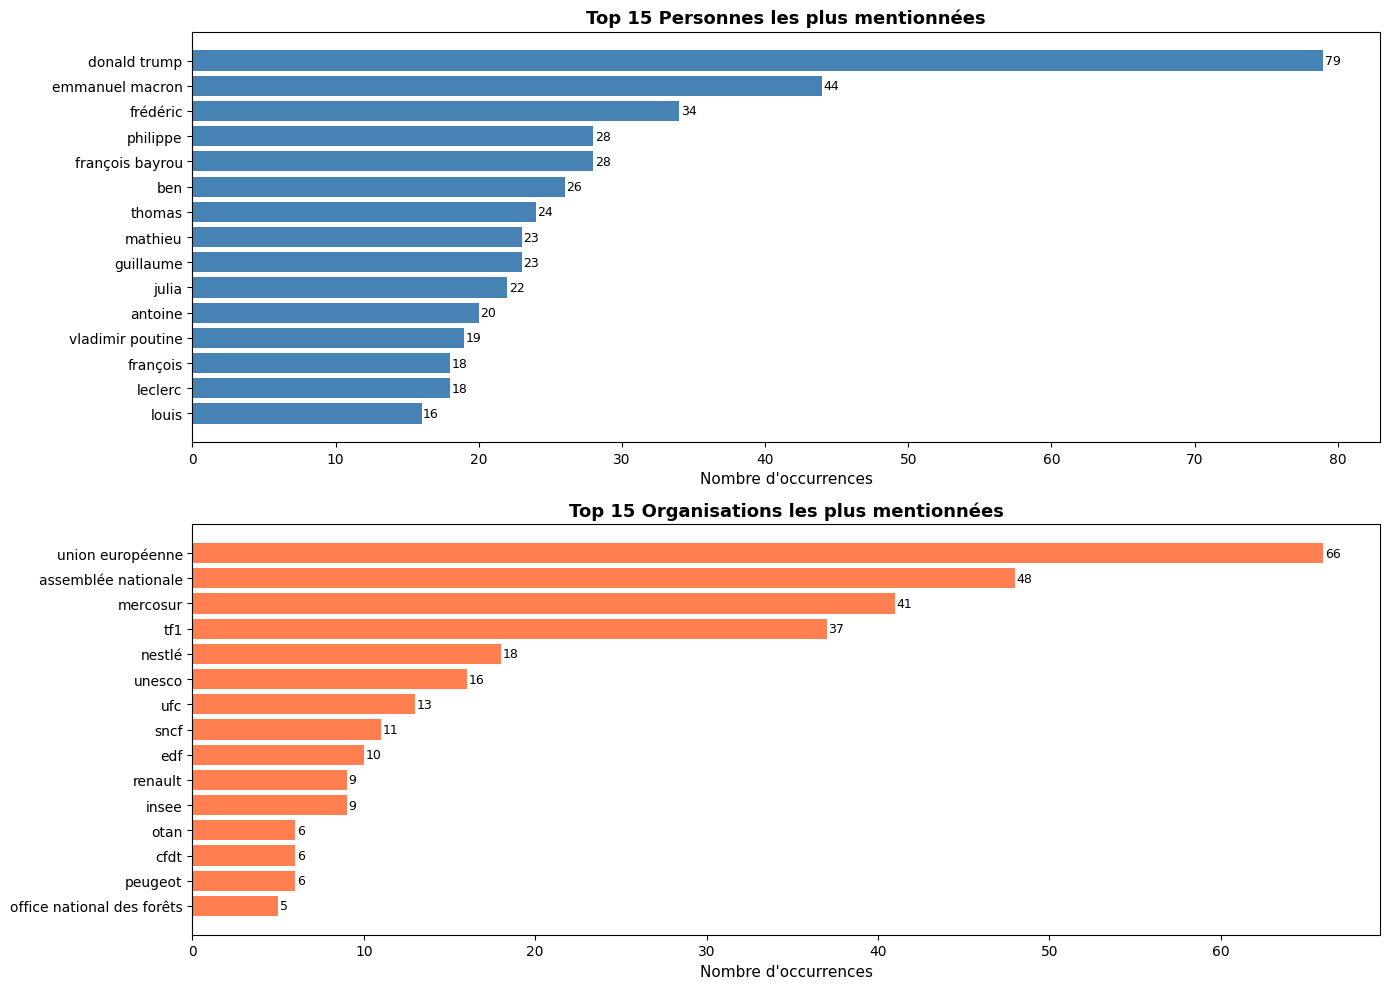

In [52]:
# Visualisation - Top acteurs
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Top 15 personnes
top_persons = persons_counter.most_common(15)
persons_names = [p[0][:40] for p in top_persons]  # Truncate long names
persons_counts = [p[1] for p in top_persons]

axes[0].barh(persons_names, persons_counts, color='steelblue')
axes[0].set_xlabel('Nombre d\'occurrences', fontsize=11)
axes[0].set_title('Top 15 Personnes les plus mentionnées', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
for i, v in enumerate(persons_counts):
    axes[0].text(v + 0.1, i, str(v), va='center', fontsize=9)

# Top 15 organisations
top_orgs = orgs_counter.most_common(15)
orgs_names = [o[0][:40] for o in top_orgs]
orgs_counts = [o[1] for o in top_orgs]

axes[1].barh(orgs_names, orgs_counts, color='coral')
axes[1].set_xlabel('Nombre d\'occurrences', fontsize=11)
axes[1].set_title('Top 15 Organisations les plus mentionnées', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
for i, v in enumerate(orgs_counts):
    axes[1].text(v + 0.1, i, str(v), va='center', fontsize=9)

plt.tight_layout()
plt.show()

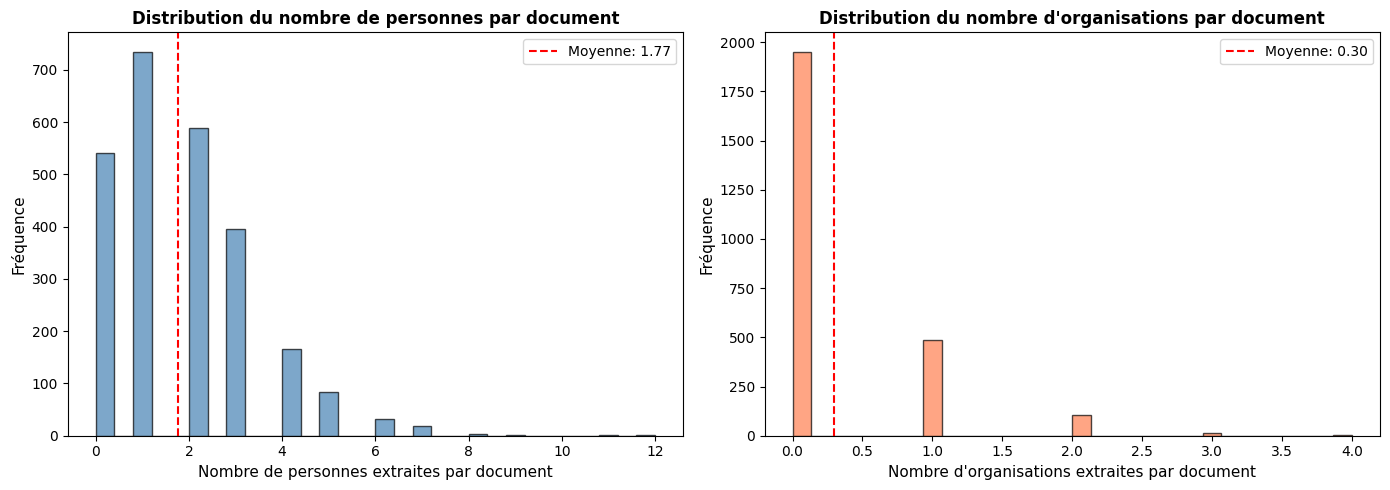


Statistiques sur le nombre d'acteurs par document:
Personnes - Min: 0, Max: 12, Moy: 1.77, Médiane: 2
Organisations - Min: 0, Max: 4, Moy: 0.30, Médiane: 0


In [53]:
# Distribution des nombres d'acteurs par document
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Nombre de personnes par document
num_persons = df_agri['actor_persons'].apply(len)
axes[0].hist(num_persons, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Nombre de personnes extraites par document', fontsize=11)
axes[0].set_ylabel('Fréquence', fontsize=11)
axes[0].set_title('Distribution du nombre de personnes par document', fontsize=12, fontweight='bold')
axes[0].axvline(num_persons.mean(), color='red', linestyle='--', label=f'Moyenne: {num_persons.mean():.2f}')
axes[0].legend()

# Nombre d'organisations par document
num_orgs = df_agri['actor_organizations'].apply(len)
axes[1].hist(num_orgs, bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Nombre d\'organisations extraites par document', fontsize=11)
axes[1].set_ylabel('Fréquence', fontsize=11)
axes[1].set_title('Distribution du nombre d\'organisations par document', fontsize=12, fontweight='bold')
axes[1].axvline(num_orgs.mean(), color='red', linestyle='--', label=f'Moyenne: {num_orgs.mean():.2f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nStatistiques sur le nombre d'acteurs par document:")
print(f"Personnes - Min: {num_persons.min()}, Max: {num_persons.max()}, Moy: {num_persons.mean():.2f}, Médiane: {num_persons.median():.0f}")
print(f"Organisations - Min: {num_orgs.min()}, Max: {num_orgs.max()}, Moy: {num_orgs.mean():.2f}, Médiane: {num_orgs.median():.0f}")

In [54]:
# Analyse des thèmes associés aux acteurs principaux
print("="*80)
print("THÈMES ASSOCIÉS AUX ACTEURS PRINCIPAUX")
print("="*80)

# Top 10 acteurs
top_10_persons = [p[0] for p in persons_counter.most_common(10)]
top_10_orgs = [o[0] for o in orgs_counter.most_common(10)]

# Pour chaque acteur principal, extraire les thèmes
for person in top_10_persons:
    rows_with_person = df_agri[df_agri['actor_persons'].apply(lambda x: person in x)]
    if len(rows_with_person) > 0:
        themes = rows_with_person['themes'].dropna()
        print(f"\n{person}:")
        print(f"  Documents: {len(rows_with_person)}")
        if len(themes) > 0 and isinstance(themes.iloc[0], (list, str)):
            print(f"  Exemple de thèmes: {themes.iloc[0]}")

THÈMES ASSOCIÉS AUX ACTEURS PRINCIPAUX

donald trump:
  Documents: 79
  Exemple de thèmes: , biodiversite_concepts_generaux_indirectes, changement_climatique_constat_indirectes

emmanuel macron:
  Documents: 44
  Exemple de thèmes: , attenuation_climatique_solutions, biodiversite_causes, biodiversite_causes_indirectes, biodiversite_concepts_generaux, biodiversite_concepts_generaux_indirectes, biodiversite_solutions, changement_climatique_causes, changement_climatique_consequences_indirectes, changement_climatique_constat, changement_climatique_constat_indirectes, ressources, ressources_indirectes, ressources_solutions

frédéric:
  Documents: 34
  Exemple de thèmes: biodiversite_concepts_generaux, biodiversite_solutions, changement_climatique_constat_indirectes, ressources_indirectes

philippe:
  Documents: 28
  Exemple de thèmes: adaptation_climatique_solutions_indirectes, attenuation_climatique_solutions_indirectes, biodiversite_causes_indirectes, biodiversite_concepts_generaux_indire

In [55]:
# Analyse de co-occurrence : personnes et organisations dans le même document
print("="*80)
print("CO-OCCURRENCE PERSONNES-ORGANISATIONS")
print("="*80)

cooccurrence = []
for idx, row in df_agri.iterrows():
    persons = row['actor_persons']
    orgs = row['actor_organizations']
    if len(persons) > 0 and len(orgs) > 0:
        for person in persons:
            for org in orgs:
                cooccurrence.append((person, org))

cooccurrence_counter = Counter(cooccurrence)
print(f"\nNombre total de paires (personne, organisation): {len(cooccurrence)}")
print(f"Nombre de paires uniques: {len(cooccurrence_counter)}")

print("\nTop 20 paires (personne, organisation):")
for (person, org), count in cooccurrence_counter.most_common(20):
    print(f"  {person:35s} <-> {org:35s} | {count} co-occurrences")

CO-OCCURRENCE PERSONNES-ORGANISATIONS

Nombre total de paires (personne, organisation): 1461
Nombre de paires uniques: 1405

Top 20 paires (personne, organisation):
  emmanuel macron                     <-> mercosur                            | 7 co-occurrences
  donald trump                        <-> union européenne                    | 5 co-occurrences
  françois bayrou                     <-> assemblée nationale                 | 4 co-occurrences
  bernard arnault                     <-> lvmh                                | 3 co-occurrences
  emmanuel                            <-> mercosur                            | 3 co-occurrences
  emmanuel                            <-> union européenne                    | 3 co-occurrences
  mathieu                             <-> union européenne                    | 3 co-occurrences
  pierre jacqueline                   <-> union européenne                    | 3 co-occurrences
  bruce toussaint                     <-> tf1              

In [57]:
# Nettoyage et affinage des entités : déduplication et normalisation
print("="*80)
print("AFFINAGE DES ENTITÉS - DÉDUPLICATION")
print("="*80)

def normalize_entity(entity: str) -> str:
    """Normalize entity names: lowercase, remove extra spaces"""
    return ' '.join(entity.lower().split())

def merge_similar_entities(entities_counter, threshold=0.85):
    """Merge similar entities using string similarity"""
    from difflib import SequenceMatcher
    
    merged = Counter()
    processed = set()
    
    for entity in entities_counter.keys():
        if entity in processed:
            continue
        
        # Trouver les entités similaires
        similar = [entity]
        for other_entity in entities_counter.keys():
            if other_entity != entity and other_entity not in processed:
                similarity = SequenceMatcher(None, entity.lower(), other_entity.lower()).ratio()
                if similarity > threshold:
                    similar.append(other_entity)
                    processed.add(other_entity)
        
        # Fusionner les entités similaires
        merged[entity] = sum(entities_counter[e] for e in similar)
        processed.add(entity)
    
    return merged

# Affiner les organisations (plus de doublons)
print("\nAffinage des organisations...")
orgs_refined = merge_similar_entities(orgs_counter, threshold=0.90)

print(f"Avant affinage: {len(orgs_counter)} organisations uniques")
print(f"Après affinage: {len(orgs_refined)} organisations uniques")

print("\nTop 15 organisations AFFINÉES:")
for org, count in orgs_refined.most_common(15):
    print(f"  {org:50s} | {count:3d} occurrences")

AFFINAGE DES ENTITÉS - DÉDUPLICATION

Affinage des organisations...
Avant affinage: 361 organisations uniques
Après affinage: 354 organisations uniques

Top 15 organisations AFFINÉES:
  union européenne                                   |  67 occurrences
  assemblée nationale                                |  49 occurrences
  mercosur                                           |  41 occurrences
  tf1                                                |  37 occurrences
  nestlé                                             |  18 occurrences
  unesco                                             |  16 occurrences
  ufc                                                |  13 occurrences
  sncf                                               |  11 occurrences
  edf                                                |  10 occurrences
  renault                                            |   9 occurrences
  insee                                              |   9 occurrences
  otan                             

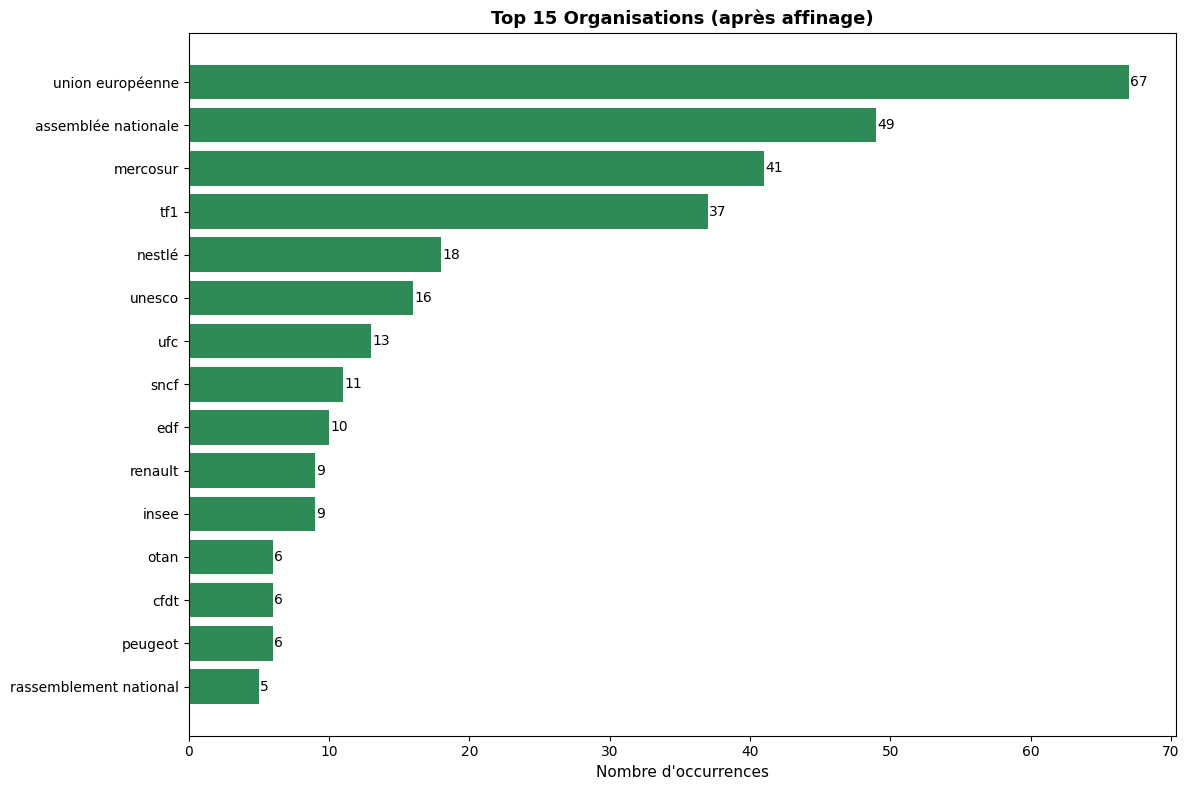

In [58]:
# Visualisation des organisations affinées
top_orgs_refined = orgs_refined.most_common(15)
orgs_names_refined = [o[0][:40] for o in top_orgs_refined]
orgs_counts_refined = [o[1] for o in top_orgs_refined]

plt.figure(figsize=(12, 8))
plt.barh(orgs_names_refined, orgs_counts_refined, color='seagreen')
plt.xlabel('Nombre d\'occurrences', fontsize=11)
plt.title('Top 15 Organisations (après affinage)', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
for i, v in enumerate(orgs_counts_refined):
    plt.text(v + 0.1, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [59]:
# Résumé final et export
print("\n" + "="*80)
print("RÉSUMÉ FINAL DE L'ANALYSE NER")
print("="*80)
print(f"\nDataset agriculture_alimentation:")
print(f"  - Nombre de documents: {len(df_agri)}")
print(f"  - Documents avec au moins une personne: {(num_persons > 0).sum()} ({(num_persons > 0).sum()/len(df_agri)*100:.1f}%)")
print(f"  - Documents avec au moins une organisation: {(num_orgs > 0).sum()} ({(num_orgs > 0).sum()/len(df_agri)*100:.1f}%)")
print(f"\nPersonnes extraites:")
print(f"  - Total unique: {len(set(all_persons))}")
print(f"  - Total d'occurrences: {len(all_persons)}")
print(f"  - Densité moyenne par document: {num_persons.mean():.2f}")
print(f"\nOrganisations extraites:")
print(f"  - Total unique (avant affinage): {len(orgs_counter)}")
print(f"  - Total unique (après affinage): {len(orgs_refined)}")
print(f"  - Total d'occurrences: {len(all_orgs)}")
print(f"  - Densité moyenne par document: {num_orgs.mean():.2f}")


RÉSUMÉ FINAL DE L'ANALYSE NER

Dataset agriculture_alimentation:
  - Nombre de documents: 2565
  - Documents avec au moins une personne: 2024 (78.9%)
  - Documents avec au moins une organisation: 613 (23.9%)

Personnes extraites:
  - Total unique: 3066
  - Total d'occurrences: 4552
  - Densité moyenne par document: 1.77

Organisations extraites:
  - Total unique (avant affinage): 361
  - Total unique (après affinage): 354
  - Total d'occurrences: 766
  - Densité moyenne par document: 0.30


## Key-words

In [22]:
pip install nltk

  Using cached nltk-3.9.2-py3-none-any.whl.metadata (3.2 kB)
Using cached nltk-3.9.2-py3-none-any.whl (1.5 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\moonb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [24]:
pip install rake-nltk

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: C:\Users\moonb\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
import sys
from pathlib import Path
import nltk
import csv
from rake_nltk.rake import Rake
from nltk.corpus import stopwords

In [26]:
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

In [29]:
french_stopwords = set(stopwords.words('french'))
rake = Rake(language="french")

In [38]:
def extract_keywords_row(text: str, rake_extractor, stopwords_set: set) -> list:
    """
    Extrait les keywords filtrés d'un texte donné
    Retourne une liste de keywords nettoyés et validés
    """
    if not isinstance(text, str) or not text.strip():
        return []
    
    # Extraire les keywords avec RAKE
    rake_extractor.extract_keywords_from_text(text)
    keywords = rake_extractor.get_ranked_phrases()
    
    filtered_keywords = []
    unique_keywords = set(keywords)
    
    for keyword in unique_keywords:
        # Nettoyer le keyword
        keyword_clean = keyword.strip().lower()
        
        # Ignorer les keywords vides ou trop courts
        if len(keyword_clean) < 3:
            continue
        
        words_in_keyword = keyword_clean.split()
        
        # Si c'est un mot unique
        if len(words_in_keyword) == 1:
            if keyword_clean in stopwords_set or keyword_clean.isdigit():
                continue
        else:
            # Pour les phrases, vérifier qu'au moins un mot n'est pas un stop word
            significant_words = [w for w in words_in_keyword 
                                if w not in stopwords_set and len(w) >= 3]
            if len(significant_words) == 0:
                continue
        
        filtered_keywords.append(keyword_clean)
    
    return filtered_keywords

# Appliquer à df_agri
df_agri["keywords"] = df_agri["report_text"].apply(
    lambda text: extract_keywords_row(text, rake, french_stopwords)
)

C:\Users\moonb\AppData\Local\Temp\ipykernel_32268\4135735115.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["keywords"] = df_agri["report_text"].apply(


In [39]:
# Appliquer à df_agri
df_agri["keywords"] = df_agri["report_text"].apply(
    lambda text: extract_keywords_row(text, rake, french_stopwords)
)

C:\Users\moonb\AppData\Local\Temp\ipykernel_32268\968886341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["keywords"] = df_agri["report_text"].apply(


In [40]:
df_agri[["keywords"]].head(10)

,keywords
2,"[voyez, radiologues, entraîne activement lucie..."
3,"[enseigne travaille, va voir si, david, cours,..."
9,"[réglementations strictes imposées, essaie, va..."
14,"[allez pouvoir, froid, herbes, myrtilles, va t..."
17,"[voyez, côté alpes, météo, peu gêné, extérieur..."
20,"[situation plus instable, vient vraiment désta..."
21,"[spectacle, ligne, peu tous, surtout chili où,..."
23,"[cochon, france, va dire, bord mer, équipes, f..."
24,"[cinq ans, a comme ambition chez bell, ramener..."
28,"[ramener, cent zéro sept, économie invité, sem..."


In [41]:
# Statistiques
print("="*80)
print("STATISTIQUES DES KEYWORDS PAR DOCUMENT")
print("="*80)
num_keywords = df_agri["keywords"].apply(len)
print(f"Nombre moyen de keywords par document: {num_keywords.mean():.2f}")
print(f"Min: {num_keywords.min()}, Max: {num_keywords.max()}")
print(f"Médiane: {num_keywords.median():.0f}")
print(f"\nDocuments avec au moins 1 keyword: {(num_keywords > 0).sum()} / {len(df_agri)}")

# Top keywords globaux
all_keywords = [kw for row in df_agri["keywords"] for kw in row]
keywords_counter = Counter(all_keywords)
print(f"\nTop 30 keywords les plus fréquents:")
for keyword, count in keywords_counter.most_common(30):
    print(f"  {keyword:50s} | {count:3d} occurrences")

STATISTIQUES DES KEYWORDS PAR DOCUMENT
Nombre moyen de keywords par document: 177.55
Min: 40, Max: 588
Médiane: 165

Documents avec au moins 1 keyword: 2565 / 2565

Top 30 keywords les plus fréquents:
  unk                                                | 1243 occurrences
  fait                                               | 1229 occurrences
  plus                                               | 1163 occurrences
  france                                             | 1080 occurrences
  hui                                                | 1004 occurrences
  vingt                                              | 872 occurrences
  tout                                               | 798 occurrences
  faire                                              | 788 occurrences
  aussi                                              | 676 occurrences
  tous                                               | 655 occurrences
  peut                                               | 604 occurrences
  cent       

In [42]:
df_agri[["keywords"]].head(10)

,keywords
2,"[voyez, radiologues, entraîne activement lucie..."
3,"[enseigne travaille, va voir si, david, cours,..."
9,"[réglementations strictes imposées, essaie, va..."
14,"[allez pouvoir, froid, herbes, myrtilles, va t..."
17,"[voyez, côté alpes, météo, peu gêné, extérieur..."
20,"[situation plus instable, vient vraiment désta..."
21,"[spectacle, ligne, peu tous, surtout chili où,..."
23,"[cochon, france, va dire, bord mer, équipes, f..."
24,"[cinq ans, a comme ambition chez bell, ramener..."
28,"[ramener, cent zéro sept, économie invité, sem..."


Filtrer les noms communs

In [44]:
# Traiter les keywords avec spaCy pour détecter les noms communs
def filter_keywords_by_nouns(keywords_list: list, nlp_model) -> dict:
    """
    Filtre les keywords en gardant seulement ceux contenant au least un nom commun
    Retourne un dict avec les keywords filtrés et leurs noms communs associés
    """
    if not keywords_list:
        return {"keywords_filtered": [], "nouns_found": []}
    
    filtered_kw = []
    all_nouns = []
    
    for keyword in keywords_list:
        doc = nlp_model(keyword)
        nouns_in_kw = [tok.text for tok in doc if tok.pos_ == "NOUN"]
        
        # Garder le keyword seulement s'il contient au moins un nom commun
        if nouns_in_kw:
            filtered_kw.append(keyword)
            all_nouns.extend(nouns_in_kw)
    
    return {
        "keywords_filtered": filtered_kw,
        "nouns_found": list(set(all_nouns))
    }

# Appliquer le filtrage à df_agri
df_agri["keywords_nouns_analysis"] = df_agri["keywords"].apply(
    lambda kw_list: filter_keywords_by_nouns(kw_list, nlp)
)

# Extraire les colonnes séparées
df_agri["keywords_filtered"] = df_agri["keywords_nouns_analysis"].apply(lambda x: x["keywords_filtered"])
df_agri["nouns_in_keywords"] = df_agri["keywords_nouns_analysis"].apply(lambda x: x["nouns_found"])

# Supprimer la colonne intermédiaire
df_agri.drop("keywords_nouns_analysis", axis=1, inplace=True)

# Aperçu
print("Exemples de keywords filtrés et noms communs détectés:")
df_agri[["keywords", "keywords_filtered", "nouns_in_keywords"]].head(10)

# Statistiques
print("\n" + "="*80)
print("STATISTIQUES DES KEYWORDS FILTRÉS (AVEC NOMS COMMUNS)")
print("="*80)
num_kw_filtered = df_agri["keywords_filtered"].apply(len)
print(f"Nombre moyen de keywords (filtrés) par document: {num_kw_filtered.mean():.2f}")
print(f"Min: {num_kw_filtered.min()}, Max: {num_kw_filtered.max()}")
print(f"Médiane: {num_kw_filtered.median():.0f}")
print(f"Documents avec au moins 1 keyword filtré: {(num_kw_filtered > 0).sum()} / {len(df_agri)}")

# Top keywords filtrés
all_kw_filtered = [kw for row in df_agri["keywords_filtered"] for kw in row]
kw_filtered_counter = Counter(all_kw_filtered)
print(f"\nTop 30 keywords filtrés (avec noms communs):")
for keyword, count in kw_filtered_counter.most_common(30):
    print(f"  {keyword:50s} | {count:3d} occurrences")

# Top noms communs extraits des keywords
all_nouns_kw = [n for row in df_agri["nouns_in_keywords"] for n in row]
nouns_kw_counter = Counter(all_nouns_kw)
print(f"\nTop 30 noms communs détectés dans les keywords:")
for noun, count in nouns_kw_counter.most_common(30):
    print(f"  {noun:50s} | {count:3d} occurrences")

C:\Users\moonb\AppData\Local\Temp\ipykernel_32268\2131752290.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["keywords_nouns_analysis"] = df_agri["keywords"].apply(
C:\Users\moonb\AppData\Local\Temp\ipykernel_32268\2131752290.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_agri["keywords_filtered"] = df_agri["keywords_nouns_analysis"].apply(lambda x: x["keywords_filtered"])
C:\Users\moonb\AppData\Local\Temp\ipykernel_32268\2131752290.py:34: SettingWithCopyWarning: 
A value is trying to 

Exemples de keywords filtrés et noms communs détectés:

STATISTIQUES DES KEYWORDS FILTRÉS (AVEC NOMS COMMUNS)
Nombre moyen de keywords (filtrés) par document: 98.51
Min: 20, Max: 351
Médiane: 90
Documents avec au moins 1 keyword filtré: 2565 / 2565

Top 30 keywords filtrés (avec noms communs):
  eau                                                | 599 occurrences
  matin                                              | 588 occurrences
  temps                                              | 570 occurrences
  production                                         | 511 occurrences
  monde                                              | 494 occurrences
  aujourd                                            | 474 occurrences
  jour                                               | 456 occurrences
  fin                                                | 450 occurrences
  moment                                             | 442 occurrences
  place                                              | 439 occurre

In [46]:
# Sauvegarder df_agri en CSV
df_agri.to_csv('df_agri_keywords.csv', index=False, encoding='utf-8')

In [47]:
# Aperçu de la colonne nouns_in_keywords
print("="*80)
print("APERÇU DE LA COLONNE nouns_in_keywords")
print("="*80)
df_agri[["nouns_in_keywords"]].head(20)

APERÇU DE LA COLONNE nouns_in_keywords


,nouns_in_keywords
2,"[concurrence, stations, résultats, direction, ..."
3,"[temps, directeurs, retraites, site, viandes, ..."
9,"[heure, mérite, sympathie, euros, réglementati..."
14,"[année, pommes, andalou, choses, limite, noël,..."
17,"[météo, choses, extérieur, règles, ensemble, a..."
20,"[choses, plantes, part, espace, sud, territoir..."
21,"[chaise, évident, année, frontalement, action,..."
23,"[traditions, cochon, production, météo, achats..."
24,"[tests, effets, préservatif, peine, défense, c..."
28,"[heure, pays, année, donald, quart, économie, ..."


In [48]:
# Analyses et visualisations des nouns_in_keywords
print("="*80)
print("ANALYSE DES NOMS COMMUNS EXTRAITS DES KEYWORDS")
print("="*80)

# 1. Statistiques de base
num_nouns = df_agri["nouns_in_keywords"].apply(len)
print(f"\nNombre moyen de noms communs par document: {num_nouns.mean():.2f}")
print(f"Min: {num_nouns.min()}, Max: {num_nouns.max()}")
print(f"Médiane: {num_nouns.median():.0f}")
print(f"Documents avec au moins 1 nom commun: {(num_nouns > 0).sum()} / {len(df_agri)}")

# 2. Collecter tous les noms communs
all_nouns_kw = [n for row in df_agri["nouns_in_keywords"] for n in row]
nouns_kw_counter = Counter(all_nouns_kw)
print(f"\nNombre total de noms communs uniques: {len(nouns_kw_counter)}")
print(f"Nombre total d'occurrences: {len(all_nouns_kw)}")

print(f"\nTop 50 noms communs les plus fréquents:")
for noun, count in nouns_kw_counter.most_common(50):
    print(f"  {noun:40s} | {count:4d} occurrences")

ANALYSE DES NOMS COMMUNS EXTRAITS DES KEYWORDS

Nombre moyen de noms communs par document: 89.56
Min: 20, Max: 293
Médiane: 83
Documents avec au moins 1 nom commun: 2565 / 2565

Nombre total de noms communs uniques: 18486
Nombre total d'occurrences: 229714

Top 50 noms communs les plus fréquents:
  ans                                      | 1397 occurrences
  fois                                     | 1082 occurrences
  année                                    | 1005 occurrences
  cents                                    |  987 occurrences
  heures                                   |  982 occurrences
  euros                                    |  942 occurrences
  mois                                     |  888 occurrences
  matin                                    |  877 occurrences
  jours                                    |  856 occurrences
  temps                                    |  826 occurrences
  eau                                      |  822 occurrences
  monde             

In [49]:
# Analyses et visualisations des nouns_in_keywords
print("="*80)
print("ANALYSE DES NOMS COMMUNS EXTRAITS DES KEYWORDS")
print("="*80)

# 1. Statistiques de base
num_nouns = df_agri["nouns_in_keywords"].apply(len)
print(f"\nNombre moyen de noms communs par document: {num_nouns.mean():.2f}")
print(f"Min: {num_nouns.min()}, Max: {num_nouns.max()}")
print(f"Médiane: {num_nouns.median():.0f}")
print(f"Documents avec au moins 1 nom commun: {(num_nouns > 0).sum()} / {len(df_agri)}")

# 2. Collecter tous les noms communs
all_nouns_kw = [n for row in df_agri["nouns_in_keywords"] for n in row]
nouns_kw_counter = Counter(all_nouns_kw)
print(f"\nNombre total de noms communs uniques: {len(nouns_kw_counter)}")
print(f"Nombre total d'occurrences: {len(all_nouns_kw)}")

print(f"\nTop 50 noms communs les plus fréquents:")
for noun, count in nouns_kw_counter.most_common(50):
    print(f"  {noun:40s} | {count:4d} occurrences")

ANALYSE DES NOMS COMMUNS EXTRAITS DES KEYWORDS

Nombre moyen de noms communs par document: 89.56
Min: 20, Max: 293
Médiane: 83
Documents avec au moins 1 nom commun: 2565 / 2565

Nombre total de noms communs uniques: 18486
Nombre total d'occurrences: 229714

Top 50 noms communs les plus fréquents:
  ans                                      | 1397 occurrences
  fois                                     | 1082 occurrences
  année                                    | 1005 occurrences
  cents                                    |  987 occurrences
  heures                                   |  982 occurrences
  euros                                    |  942 occurrences
  mois                                     |  888 occurrences
  matin                                    |  877 occurrences
  jours                                    |  856 occurrences
  temps                                    |  826 occurrences
  eau                                      |  822 occurrences
  monde             

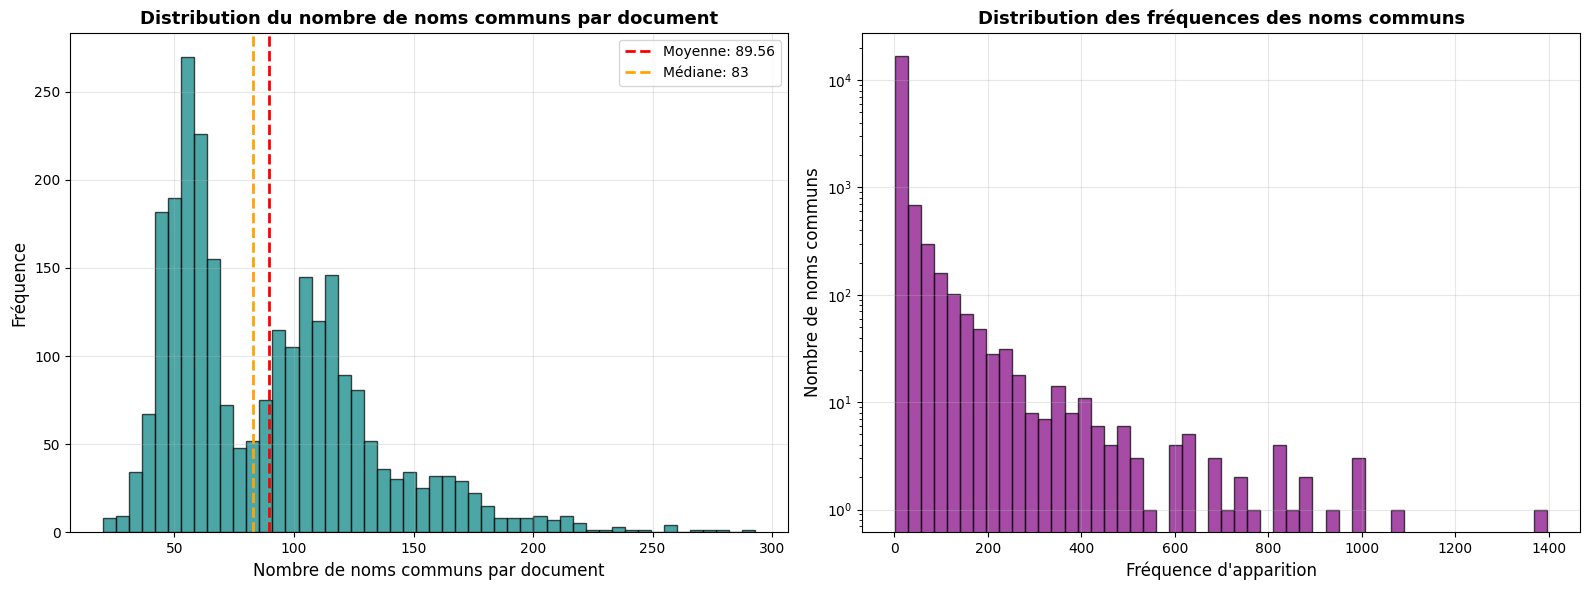

In [51]:
# VISUALISATIONS

# 1. Distribution du nombre de noms communs par document
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].hist(num_nouns, bins=50, color='teal', edgecolor='black', alpha=0.7)
axes[0].axvline(num_nouns.mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {num_nouns.mean():.2f}')
axes[0].axvline(num_nouns.median(), color='orange', linestyle='--', linewidth=2, label=f'Médiane: {num_nouns.median():.0f}')
axes[0].set_xlabel('Nombre de noms communs par document', fontsize=12)
axes[0].set_ylabel('Fréquence', fontsize=12)
axes[0].set_title('Distribution du nombre de noms communs par document', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2. Distribution des fréquences des noms communs (log scale)
noun_frequencies = list(nouns_kw_counter.values())
axes[1].hist(noun_frequencies, bins=50, color='purple', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Fréquence d\'apparition', fontsize=12)
axes[1].set_ylabel('Nombre de noms communs', fontsize=12)
axes[1].set_title('Distribution des fréquences des noms communs', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

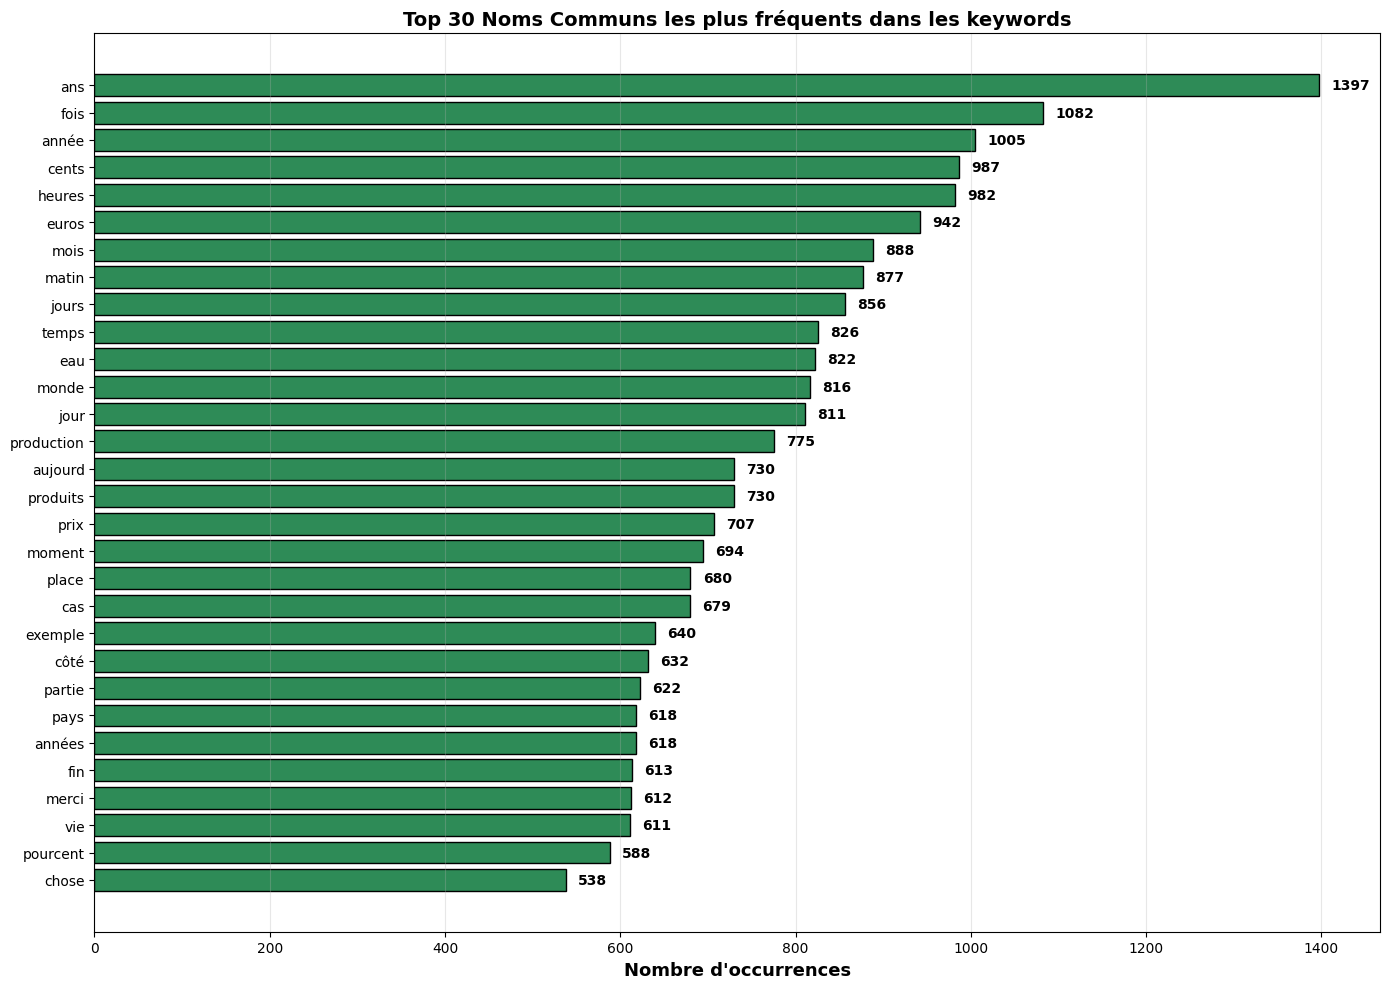

In [52]:
# 3. Top 30 noms communs - Graphique horizontal
top_30_nouns = nouns_kw_counter.most_common(30)
nouns_names = [n[0] for n in top_30_nouns]
nouns_counts = [n[1] for n in top_30_nouns]

plt.figure(figsize=(14, 10))
plt.barh(nouns_names, nouns_counts, color='seagreen', edgecolor='black')
plt.xlabel('Nombre d\'occurrences', fontsize=13, fontweight='bold')
plt.title('Top 30 Noms Communs les plus fréquents dans les keywords', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Ajouter les valeurs sur les barres
for i, v in enumerate(nouns_counts):
    plt.text(v + max(nouns_counts)*0.01, i, str(v), va='center', fontsize=10, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()